The following is a basic code I've constructed just to resize the image and output it. This is going to require a lot more work, but I just wanted to take one shot at it to see how it goes.


In [2]:
#Imports for the specific code
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


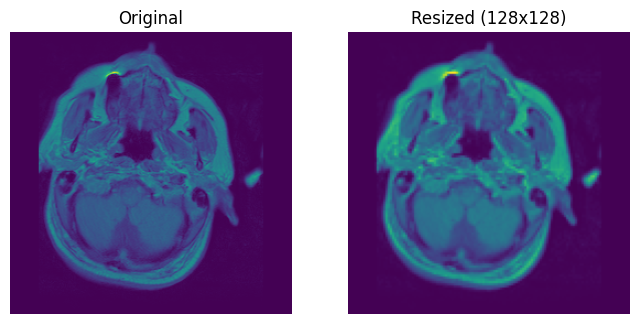

In [11]:
#load the URL for my GitHub
url = "https://raw.githubusercontent.com/Aditsmishra2005/APS360---Project/a196288235d31cf3424d16974f04825152ef569a/parkinsons_dataset1/parkinson/DUAL_TSE_001.png"
result = requests.get(url)
photo = Image.open(BytesIO(result.content))

photo_resized = photo.resize((128,128))
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

#Duisplay the Original for a reference
axes[0].imshow(photo)
axes[0].set_title("Original")
axes[0].axis("off")

#Display the resized for a reference
axes[1].imshow(photo_resized)
axes[1].set_title("Resized (128x128)")
axes[1].axis("off")

plt.show()